In [3]:
from dotenv import load_dotenv
load_dotenv()
import os

os.environ["GOOGLE_API_KEY"]=os.getenv("GOOGLE_API_KEY")


In [4]:
from typing import Annotated
from typing_extensions import TypedDict

from langgraph.graph.message import add_messages

class OrderState(TypedDict):
    """State representing the customer's order conversation."""

    # The chat conversation. This preserves the conversation history
    # between nodes. The `add_messages` annotation indicates to LangGraph
    # that state is updated by appending returned messages, not replacing
    # them.
    messages: Annotated[list, add_messages]

    # The Customer's in-progress order.
    order: list[str]

    # Flag indicating that the order is placed and completed.
    finished: bool

# The system instruction defines how the chatbot is expected to behave and includes
# rules for when to call different functions, as well as rules for the conversation, such
# as tone and what is permitted for discussion.
BARISTABOT_SYSINT = (
    "system",  # 'system' indicates the message is a system instruction.
    "You are a BaristaBot, an interactive cafe ordering system. A human will talk to you about the "
    "available products you have and you will answer any questions about menu items (and only about "
    "menu items - no off-topic discussion, but you can chat about the products and their history). "
    "The customer will place an order for 1 or more items from the menu, which you will structure "
    "and send to the ordering system after confirming the order with the human. "
    "\n\n"
    "Add items to the customer's order with add_to_order, and reset the order with clear_order. "
    "To see the contents of the order so far, call get_order (this is shown to you, not the user) "
    "Always confirm_order with the user (double-check) before calling place_order. Calling confirm_order will "
    "display the order items to the user and returns their response to seeing the list. Their response may contain modifications. "
    "Always verify and respond with drink and modifier names from the MENU before adding them to the order. "
    "If you are unsure a drink or modifier matches those on the MENU, ask a question to clarify or redirect. "
    "You only have the modifiers listed on the menu. "
    "Once the customer has finished ordering items, Call confirm_order to ensure it is correct then make "
    "any necessary updates and then call place_order. Once place_order has returned, thank the user and "
    "say goodbye!"
    "\n\n"
    "If any of the tools are unavailable, you can break the fourth wall and tell the user that "
    "they have not implemented them yet and should keep reading to do so.",
)

# This is the message with which the system opens the conversation.
WELCOME_MSG = "Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?"

In [5]:
from langgraph.graph import StateGraph, START, END
from langchain_google_genai import ChatGoogleGenerativeAI

llm = ChatGoogleGenerativeAI(model="gemini-2.0-flash")

def chatbot(state: OrderState) -> OrderState:
    """The chatbot itself. A Simple wrapper around the model's own chat interface"""
    message_history = [BARISTABOT_SYSINT] + state["messages"]
    return {"messages": [llm.invoke(message_history)]}

# Setup the initial graph based on our state definition.
graph_builder = StateGraph(OrderState)

# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node("chatbot", chatbot)

# Define the chatbot node as the app environment.
graph_builder.add_edge(START, "chatbot")

chat_graph = graph_builder.compile()

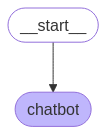

In [6]:
from IPython.display import Image, display

Image(chat_graph.get_graph().draw_mermaid_png())

In [8]:
from pprint import pprint

user_msg = "Hello, What you can do ?"
state = chat_graph.invoke({"messages": [user_msg]})

#pprint(state)

for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, What you can do ?
AIMessage: Hello! I am BaristaBot, your interactive cafe ordering system. I can tell you about the menu items, answer questions about them, and take your order.


In [9]:
user_msg = "Oh great, what kind of latte can you make?"

state["messages"].append(user_msg)
state = chat_graph.invoke(state)

for msg in state["messages"]:
    print(f"{type(msg).__name__}: {msg.content}")

HumanMessage: Hello, What you can do ?
AIMessage: Hello! I am BaristaBot, your interactive cafe ordering system. I can tell you about the menu items, answer questions about them, and take your order.
HumanMessage: Oh great, what kind of latte can you make?
AIMessage: We have a few lattes on the menu: Latte, Vanilla Latte, Caramel Latte, and Mocha Latte.


In [10]:
from langchain_core.messages.ai import AIMessage

def human_node(state: OrderState) -> OrderState:
    """Display the last model message to the user and receive the input"""
    last_msg = state["messages"][-1]
    print("Model:", last_msg.content)

    user_input = input("User: ")

    # If it looks like the user is trying to quit, flag the conversation
    # as over.
    if user_input in {"q", "quit", "exit", "goodbye"}:
        state["finished"] = True

    return state | {"messages": [("user", user_input)]}


def chatbot_with_welcome_msg(state: OrderState) -> OrderState:
    """The chatbot itself. A wrapper around the model's own chat interface."""

    if state["messages"]:
        new_output = llm.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    return state | {"messages": [new_output]}

graph_builder = StateGraph(OrderState)

# Add the chatbot function to the app graph as a node called "chatbot".
graph_builder.add_node("chatbot", chatbot_with_welcome_msg)
graph_builder.add_node("human", human_node)

# Define the chatbot node as the app environment.
graph_builder.add_edge(START, "chatbot")

# The chatbot will always go to the human next.
graph_builder.add_edge("chatbot", "human")

In [13]:
from typing import Literal

def maybe_exit_human_node(state: OrderState) -> Literal["chatbot", "__end__"]:
    if state.get("finished", False):
        return END
    else:
        return "chatbot"
    
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

chat_with_human_graph = graph_builder.compile()

Image(chat_with_human_graph.get_graph().draw_mermaid_png())

Adding an edge to a graph that has already been compiled. This will not be reflected in the compiled graph.


ValueError: Branch with name `maybe_exit_human_node` already exists for node `human`

In [14]:
# The default recursion limit for traversing nodes is 25 - setting it higher means
# you can try a more complex order with multiple steps and round-trips (and you
# can chat for longer!)
config = {"recursion_limit": 100}

# Remember that this will loop forever, unless you input `q`, `quit` or one of the
# other exit terms defined in `human_node`.
# Uncomment this line to execute the graph:
state = chatbot_with_human_graph.invoke({"messages": []}, config)

# Things to try:
#  - Just chat! There's no ordering or menu yet.
#  - 'q' to exit.

# pprint(state)

Model: Welcome to the BaristaBot cafe. Type `q` to quit. How may I serve you today?
Model: We have a Latte, Vanilla Latte, Caramel Latte, and Mocha Latte.
Model: The Mocha Latte contains coffee, steamed milk, chocolate syrup, and whipped cream. It's a delicious chocolatey coffee!
Model: I can only offer the modifiers listed on the menu. Are you interested in adding any of those to your Mocha Latte?
Model: Could you please specify which modifiers you would like to add?
Model: We offer whole milk, skim milk, oat milk, and soy milk. Which milk would you prefer in your Mocha Latte?


In [15]:
from langchain_core.tools import tool

@tool
def get_menu() -> str:
    """Provie the latest menu"""

    return """
    MENU:
    Coffee Drinks:
    Espresso
    Americano
    Cold Brew

    Coffee Drinks with Milk:
    Latte
    Cappuccino
    Cortado
    Macchiato
    Mocha
    Flat White

    Tea Drinks:
    English Breakfast Tea
    Green Tea
    Earl Grey

    Tea Drinks with Milk:
    Chai Latte
    Matcha Latte
    London Fog

    Other Drinks:
    Steamer
    Hot Chocolate

    Modifiers:
    Milk options: Whole, 2%, Oat, Almond, 2% Lactose Free; Default option: whole
    Espresso shots: Single, Double, Triple, Quadruple; default: Double
    Caffeine: Decaf, Regular; default: Regular
    Hot-Iced: Hot, Iced; Default: Hot
    Sweeteners (option to add one or more): vanilla sweetener, hazelnut sweetener, caramel sauce, chocolate sauce, sugar free vanilla sweetener
    Special requests: any reasonable modification that does not involve items not on the menu, for example: 'extra hot', 'one pump', 'half caff', 'extra foam', etc.

    "dirty" means add a shot of espresso to a drink that doesn't usually have it, like "Dirty Chai Latte".
    "Regular milk" is the same as 'whole milk'.
    "Sweetened" means add some regular sugar, not a sweetener.

    Soy milk has run out of stock today, so soy is not available.
  """

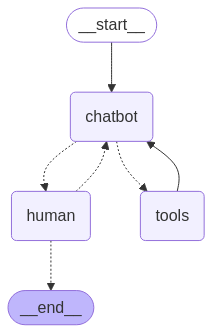

In [16]:
from langgraph.prebuilt import ToolNode

tools = [get_menu]
tool_node = ToolNode(tools)

llm_with_tools = llm.bind_tools(tools)

def maybe_route_to_tools(state: OrderState) -> Literal["tools", "human"]:
    if not (msgs := state.get("messages", [])):
        raise ValueError(f"No messages found when parsing state: {state}")
    
    msg = msgs[-1]

    if hasattr(msg, "tool_calls") and len(msg.tool_calls) > 0:
        return "tools"
    else:
        return "human"
    
def chatbot_with_tools(state: OrderState) -> OrderState:
    """The chatbot with tools. A simple wrapper around the model's own chatbot"""
    defaults = {"order": [], "finished": False}

    if state["messages"]:
        new_output = llm_with_tools.invoke([BARISTABOT_SYSINT] + state["messages"])
    else:
        new_output = AIMessage(content=WELCOME_MSG)

    return defaults | state | {"messages": [new_output]}

graph_builder = StateGraph(OrderState)

graph_builder.add_node("chatbot", chatbot_with_tools)
graph_builder.add_node("human", human_node)
graph_builder.add_node("tools", tool_node)

graph_builder.add_conditional_edges("chatbot", maybe_route_to_tools)
graph_builder.add_conditional_edges("human", maybe_exit_human_node)

graph_builder.add_edge("tools", "chatbot")

graph_builder.add_edge(START, "chatbot")
graph_with_menu = graph_builder.compile()

Image(graph_with_menu.get_graph().draw_mermaid_png())